# Previsão de Sucesso de Startups

**Objetivo:** Construir um modelo supervisionado (classificação binária) para prever se uma startup terá sucesso (`labels = 1`) usando dados de financiamento, setor, localização e marcos.

**Público-alvo:** Investidores e aceleradora (decisões de portfólio, priorização de due diligence).

**Abordagem geral:**
- Exploração dos dados (qualidade, distribuições, correlações, relação com `labels`).
- Formulação de hipóteses de negócio.
- Pipeline reprodutível de pré-processamento (imputação, codificação, escala).
- Avaliação robusta com validação cruzada estratificada e múltiplas métricas (considerando possível desbalanceamento).
- Tuning de hiperparâmetros e geração de arquivo de submissão.

## Sumário das Seções
1. Introdução
2. EDA (Análise Exploratória)
3. Hipóteses
4. Pré-processamento & Feature Engineering
5. Modelos Baseline & Avaliação
6. Otimização de Hiperparâmetros
7. Modelo Final & Submissão
8. Avaliação Final do Modelo
9. Próximos Passos

In [26]:
# Imports e configurações gerais
import os
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_validate, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, 
                           confusion_matrix, classification_report, roc_curve, auc)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Configurações de visualização em português
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 11
plt.style.use('default')
sns.set_palette("husl")

# Configurações para garantir reprodutibilidade
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

print("✅ Bibliotecas carregadas com sucesso!")
print("📊 Matplotlib e Seaborn configurados para gráficos em português")
print(f"🎲 Seed aleatória definida: {RANDOM_STATE}")

✅ Bibliotecas carregadas com sucesso!
📊 Matplotlib e Seaborn configurados para gráficos em português
🎲 Seed aleatória definida: 42


In [27]:
# Carregamento dos dados
train_path = 'train.csv'
test_path = 'test.csv'
sample_path = 'sample_submission.csv'

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
sample_submission = pd.read_csv(sample_path)

print(f'Dimensões dos dados de treino: {train.shape}')
print(f'Dimensões dos dados de teste: {test.shape}')
print(f'Primeiras 3 linhas dos dados de treino:')
display(train.head(3))

Dimensões dos dados de treino: (646, 33)
Dimensões dos dados de teste: (277, 32)
Primeiras 3 linhas dos dados de treino:


,id,age_first_funding_year,age_last_funding_year,age_first_milestone_year,age_last_milestone_year,relationships,funding_rounds,funding_total_usd,milestones,is_CA,is_NY,is_MA,is_TX,is_otherstate,category_code,is_software,is_web,is_mobile,is_enterprise,is_advertising,is_gamesvideo,is_ecommerce,is_biotech,is_consulting,is_othercategory,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,labels
0,719,10.42,13.09,8.98,12.72,4,3,4087500,3,1,0,0,0,0,enterprise,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1.0,0
1,429,3.79,3.79,NaN,NaN,21,1,45000000,0,0,1,0,0,0,advertising,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1.0,1
2,178,0.71,2.28,1.95,2.28,5,2,5200000,2,1,0,0,0,0,photo_video,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,1.0,0


### Visão Inicial dos Dados
- Conferir tipos, nulos e possíveis variáveis-chave (e.g., `funding_total_usd`, `category_code`, `relationships`, anos de funding, sinalizadores de investimento).
- Identificar necessidade de normalização e codificação.
- Confirmar existência da coluna alvo `labels` apenas em `train`.

In [28]:
# Informações gerais e nulos
print('=== ANÁLISE INICIAL DOS DADOS ===\n')
print('Tipos de dados no conjunto de treino:')
print(train.dtypes.value_counts())

print('\n--- Valores Nulos (Treino) ---')
nulos_train = train.isna().sum().sort_values(ascending=False)
print(f'Colunas com valores nulos: {(nulos_train > 0).sum()}')
display(nulos_train.head(15))

print('\n--- Valores Nulos (Teste) ---')
nulos_test = test.isna().sum().sort_values(ascending=False) 
print(f'Colunas com valores nulos: {(nulos_test > 0).sum()}')
display(nulos_test.head(10))

# Separação dinâmica de colunas
target_col = 'labels'
id_col = 'id' if 'id' in train.columns else None
feature_cols = [c for c in train.columns if c not in [target_col]]
numeric_cols = [c for c in feature_cols if pd.api.types.is_numeric_dtype(train[c]) and c != id_col]
categorical_cols = [c for c in feature_cols if c not in numeric_cols and c != id_col]

print(f'\n--- Resumo das Variáveis ---')
print(f'Variáveis numéricas ({len(numeric_cols)}): {numeric_cols[:5]}...')
print(f'Variáveis categóricas ({len(categorical_cols)}): {categorical_cols}')
print(f'Variável alvo: {target_col}')
print(f'ID: {id_col}')

=== ANÁLISE INICIAL DOS DADOS ===

Tipos de dados no conjunto de treino:
int64      27
float64     5
object      1
Name: count, dtype: int64

--- Valores Nulos (Treino) ---
Colunas com valores nulos: 4


age_first_milestone_year    138
age_last_milestone_year     111
age_first_funding_year       35
age_last_funding_year         9
id                            0
relationships                 0
funding_rounds                0
funding_total_usd             0
milestones                    0
is_CA                         0
is_NY                         0
is_MA                         0
is_TX                         0
is_otherstate                 0
category_code                 0
dtype: int64


--- Valores Nulos (Teste) ---
Colunas com valores nulos: 4


age_first_milestone_year    60
age_last_milestone_year     53
age_first_funding_year      11
age_last_funding_year        4
id                           0
relationships                0
funding_rounds               0
funding_total_usd            0
milestones                   0
is_CA                        0
dtype: int64


--- Resumo das Variáveis ---
Variáveis numéricas (30): ['age_first_funding_year', 'age_last_funding_year', 'age_first_milestone_year', 'age_last_milestone_year', 'relationships']...
Variáveis categóricas (1): ['category_code']
Variável alvo: labels
ID: id


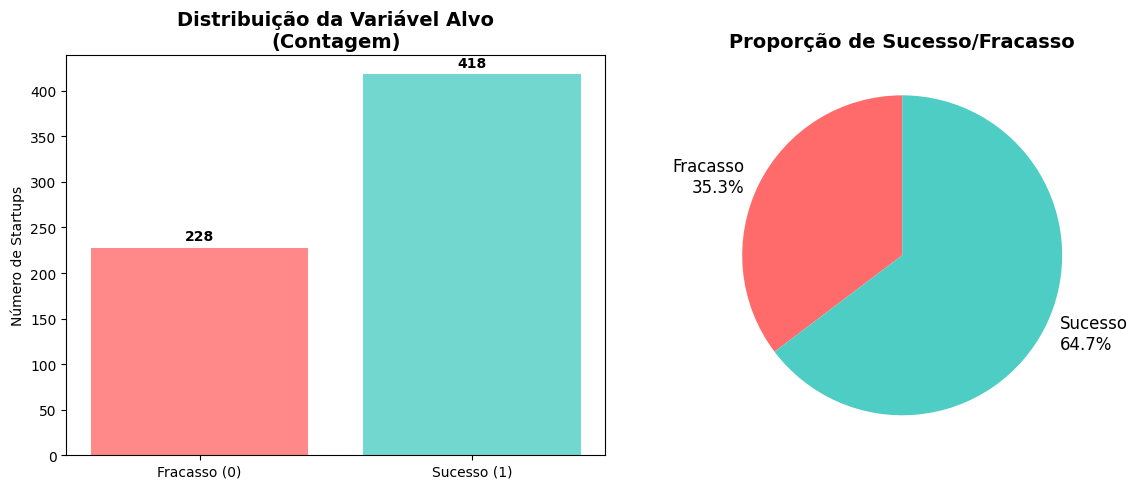


=== ANÁLISE DE BALANCEAMENTO ===
Total de startups: 646
Startups com sucesso: 418 (64.7%)
Startups com fracasso: 228 (35.3%)
Razão de balanceamento: 54.6% (Balanceado)


In [29]:
# Distribuição da variável alvo
target_counts = train[target_col].value_counts().sort_index()
target_props = (target_counts / target_counts.sum() * 100).round(1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Gráfico de barras - contagem
bars1 = ax1.bar(['Fracasso (0)', 'Sucesso (1)'], target_counts.values, 
               color=['#ff6b6b', '#4ecdc4'], alpha=0.8)
ax1.set_title('Distribuição da Variável Alvo\n(Contagem)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Número de Startups')
for i, (bar, count) in enumerate(zip(bars1, target_counts.values)):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
             f'{count}', ha='center', va='bottom', fontweight='bold')

# Gráfico de pizza - proporção  
colors = ['#ff6b6b', '#4ecdc4']
ax2.pie(target_counts.values, labels=[f'Fracasso\n{target_props[0]}%', f'Sucesso\n{target_props[1]}%'], 
        colors=colors, autopct='', startangle=90, textprops={'fontsize': 12})
ax2.set_title('Proporção de Sucesso/Fracasso', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Análise de balanceamento
print(f'\n=== ANÁLISE DE BALANCEAMENTO ===')
print(f'Total de startups: {len(train)}')
print(f'Startups com sucesso: {target_counts[1]} ({target_props[1]}%)')
print(f'Startups com fracasso: {target_counts[0]} ({target_props[0]}%)')
ratio = min(target_props) / max(target_props) * 100
print(f'Razão de balanceamento: {ratio:.1f}% ({"Balanceado" if ratio > 40 else "Desbalanceado"})')

**Observação sobre Balanceamento:**
Com base na análise acima, se a classe minoritária for < 40%, consideraremos o dataset desbalanceado e utilizaremos métricas apropriadas (Recall, F1, ROC AUC) e `class_weight='balanced'` nos modelos.

=== ANÁLISE DAS VARIÁVEIS NUMÉRICAS ===



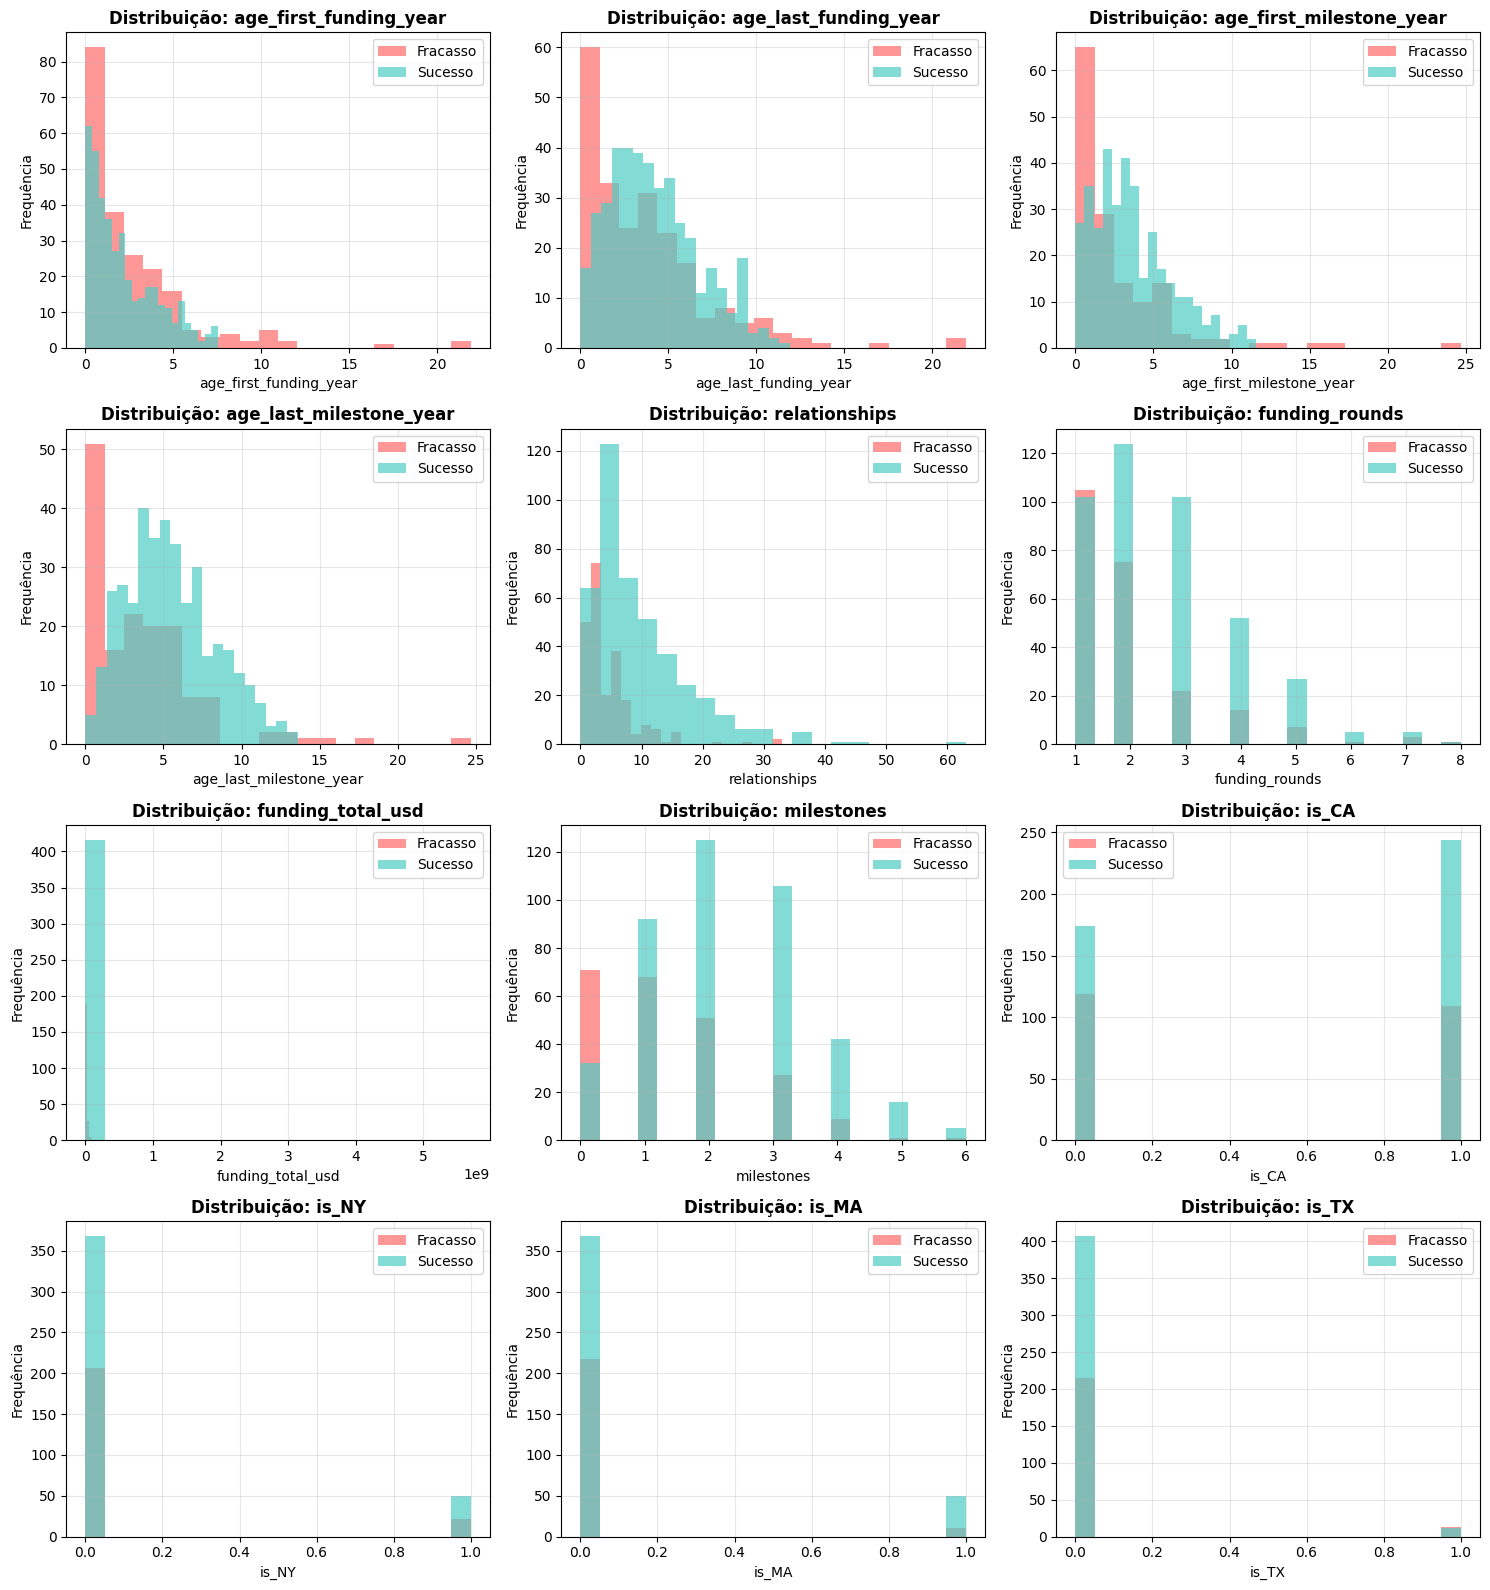


Estatísticas Descritivas das Variáveis Numéricas Principais:

--- FUNDING_TOTAL_USD ---


,count,mean,median,std
Fracasso,228,16130874.94,5000000.0,4.088613e+07
Sucesso,418,36786577.99,13000000.0,2.794303e+08



--- RELATIONSHIPS ---


,count,mean,median,std
Fracasso,228,4.52,3.0,4.76
Sucesso,418,9.82,7.0,7.90



--- FUNDING_ROUNDS ---


,count,mean,median,std
Fracasso,228,1.96,2.0,1.28
Sucesso,418,2.56,2.0,1.35



--- MILESTONES ---


,count,mean,median,std
Fracasso,228,1.31,1.0,1.21
Sucesso,418,2.24,2.0,1.29


In [30]:
# Distribuições de variáveis numéricas por classe
print('=== ANÁLISE DAS VARIÁVEIS NUMÉRICAS ===\n')

# Selecionamos as mais importantes para visualização
cols_plot = numeric_cols[:12] if len(numeric_cols) > 12 else numeric_cols
n = len(cols_plot)
ncols = 3
nrows = int(np.ceil(n / ncols)) if n > 0 else 0

if n > 0:
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 4*nrows))
    if nrows == 1:
        axes = [axes] if ncols == 1 else axes
    else:
        axes = axes.flatten()
    
    for i, col in enumerate(cols_plot):
        # Histograma por classe
        for label in [0, 1]:
            data = train[train[target_col] == label][col].dropna()
            axes[i].hist(data, bins=20, alpha=0.7, 
                        label=f'{"Fracasso" if label == 0 else "Sucesso"}',
                        color='#ff6b6b' if label == 0 else '#4ecdc4')
        
        axes[i].set_title(f'Distribuição: {col}', fontweight='bold')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequência')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
    
    # Remove eixos extras
    for j in range(i+1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

    # Estatísticas descritivas por classe
    print('\nEstatísticas Descritivas das Variáveis Numéricas Principais:')
    principais = ['funding_total_usd', 'relationships', 'funding_rounds', 'milestones'] 
    for col in principais:
        if col in train.columns:
            print(f'\n--- {col.upper()} ---')
            stats = train.groupby(target_col)[col].agg(['count', 'mean', 'median', 'std']).round(2)
            stats.index = ['Fracasso', 'Sucesso']
            display(stats)

=== ANÁLISE DE CORRELAÇÃO ===



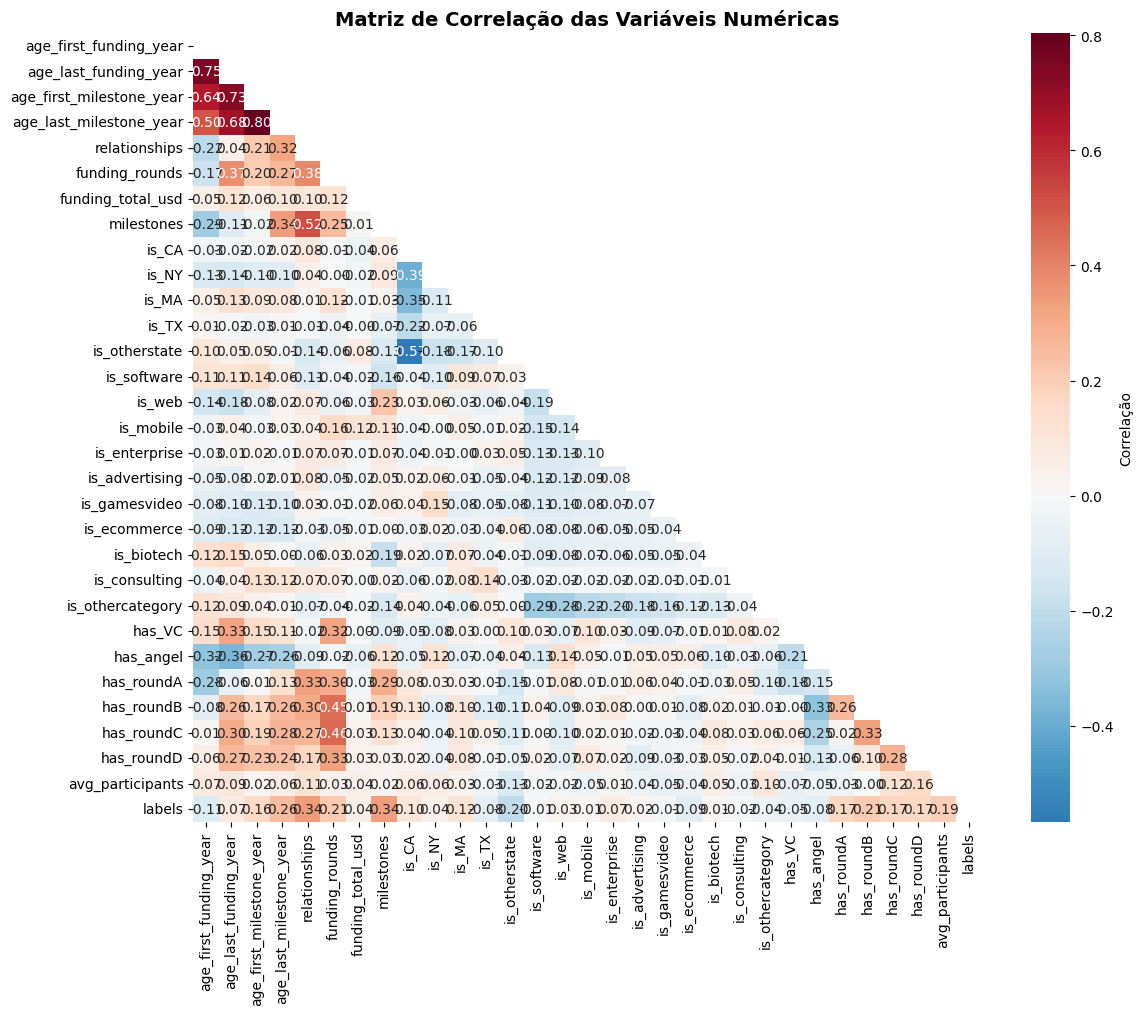

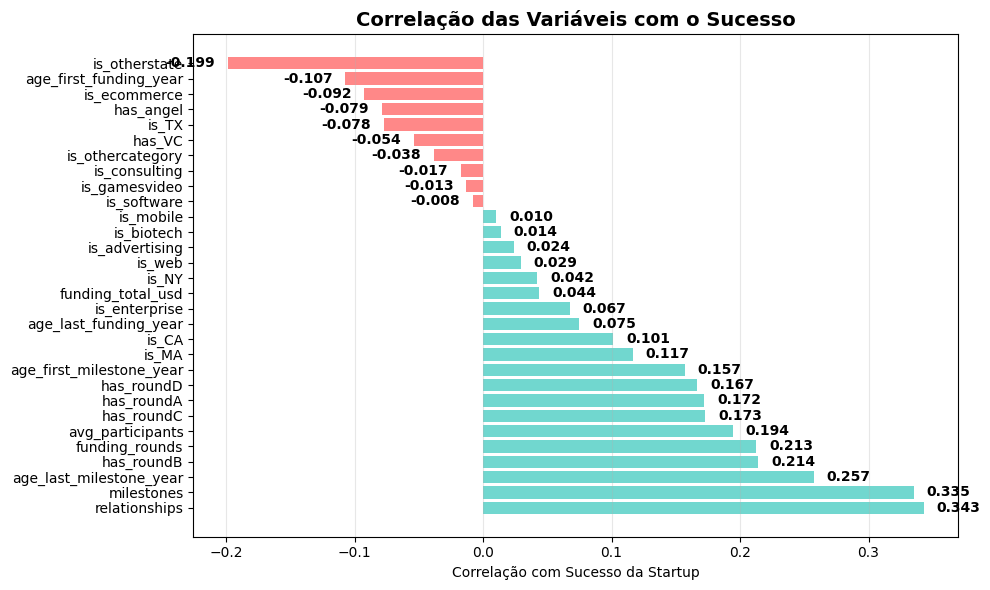

TOP 10 Correlações Positivas com Sucesso:


,Correlação
relationships,0.342841
milestones,0.335149
age_last_milestone_year,0.257261
has_roundB,0.214299
funding_rounds,0.212760
avg_participants,0.194482
has_roundC,0.172943
has_roundA,0.171953
has_roundD,0.166680
age_first_milestone_year,0.156837


In [31]:
# Análise de correlação (numéricas)
print('=== ANÁLISE DE CORRELAÇÃO ===\n')

if len(numeric_cols) > 1:
    # Matriz de correlação
    corr_data = train[numeric_cols + [target_col]]
    correlation_matrix = corr_data.corr()
    
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdBu_r', 
                center=0, fmt='.2f', square=True, cbar_kws={'label': 'Correlação'})
    plt.title('Matriz de Correlação das Variáveis Numéricas', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Correlações com a variável alvo
    target_correlations = correlation_matrix[target_col].drop(target_col).sort_values(ascending=False)
    
    plt.figure(figsize=(10, 6))
    colors = ['#4ecdc4' if x > 0 else '#ff6b6b' for x in target_correlations.values]
    bars = plt.barh(range(len(target_correlations)), target_correlations.values, color=colors, alpha=0.8)
    plt.yticks(range(len(target_correlations)), target_correlations.index)
    plt.xlabel('Correlação com Sucesso da Startup')
    plt.title('Correlação das Variáveis com o Sucesso', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3, axis='x')
    
    # Adiciona valores nas barras
    for i, (bar, val) in enumerate(zip(bars, target_correlations.values)):
        plt.text(val + (0.01 if val > 0 else -0.01), bar.get_y() + bar.get_height()/2, 
                f'{val:.3f}', ha='left' if val > 0 else 'right', va='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print('TOP 10 Correlações Positivas com Sucesso:')
    display(target_correlations.head(10).to_frame('Correlação'))

=== ANÁLISE DAS VARIÁVEIS CATEGÓRICAS ===

ANÁLISE DETALHADA: CATEGORY_CODE


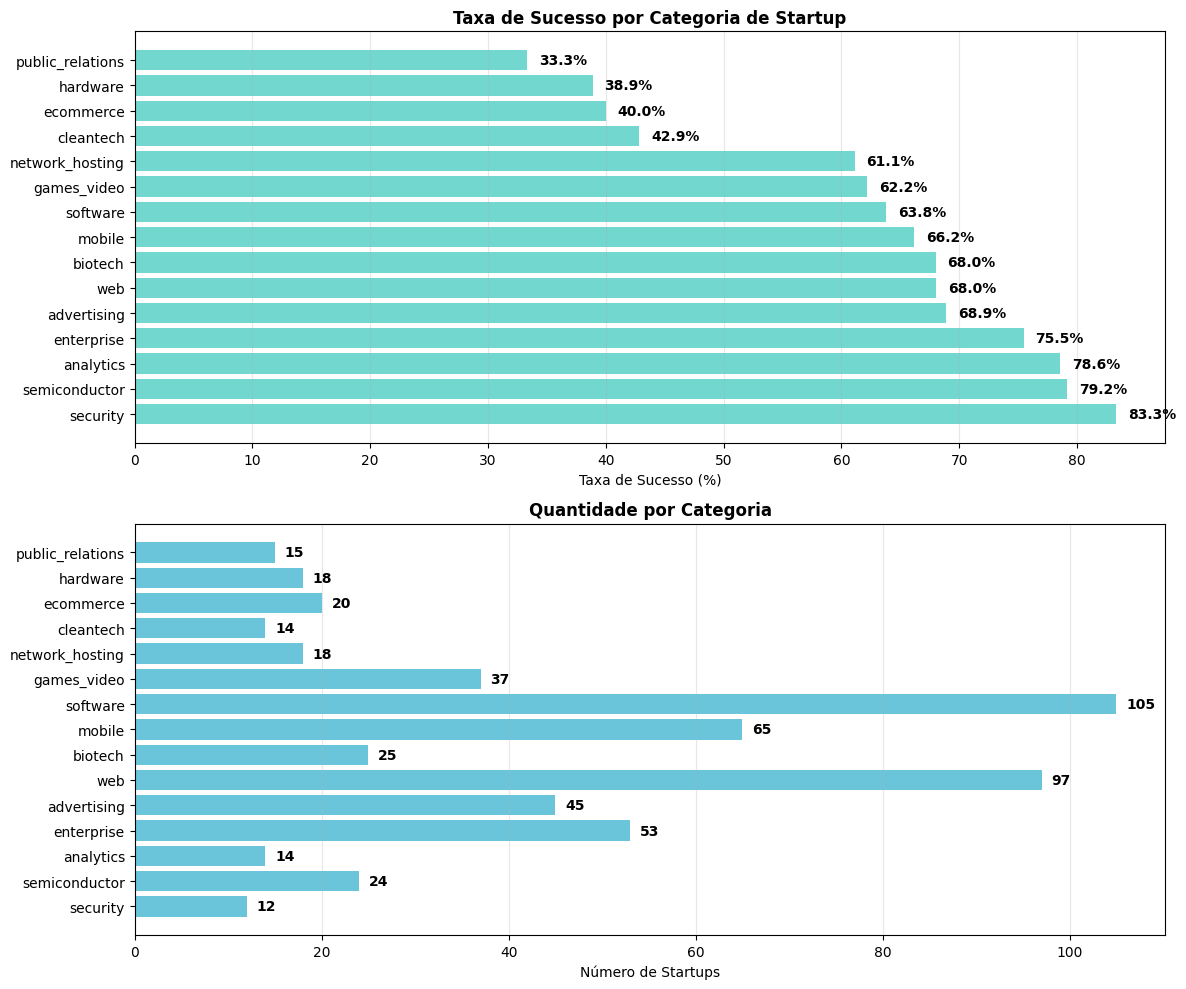


Resumo Estatístico por Categoria:


,taxa_sucesso,freq
category_code,,
security,0.833,12
semiconductor,0.792,24
analytics,0.786,14
enterprise,0.755,53
advertising,0.689,45
web,0.680,97
biotech,0.680,25
mobile,0.662,65
software,0.638,105



--- Outras Variáveis Categóricas ---


In [32]:
# Análise de variáveis categóricas
print('=== ANÁLISE DAS VARIÁVEIS CATEGÓRICAS ===\n')

def categorical_summary(col, top=8):
    """Análise de uma variável categórica"""
    vc = train[col].value_counts().head(top)
    df_rate = (train[train[col].isin(vc.index)]
               .groupby(col)[target_col]
               .agg(['mean','count'])
               .rename(columns={'mean':'taxa_sucesso','count':'freq'}))
    df_rate = df_rate.sort_values('taxa_sucesso', ascending=False)
    return df_rate

# Analisar category_code em detalhes (principal variável categórica)
if 'category_code' in categorical_cols:
    print('ANÁLISE DETALHADA: CATEGORY_CODE')
    
    cat_summary = categorical_summary('category_code', top=15)
    
    # Gráfico de taxa de sucesso por categoria
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Taxa de sucesso
    bars1 = ax1.barh(range(len(cat_summary)), cat_summary['taxa_sucesso'] * 100, 
                    color='#4ecdc4', alpha=0.8)
    ax1.set_yticks(range(len(cat_summary)))
    ax1.set_yticklabels(cat_summary.index)
    ax1.set_xlabel('Taxa de Sucesso (%)')
    ax1.set_title('Taxa de Sucesso por Categoria de Startup', fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='x')
    
    for i, (bar, val) in enumerate(zip(bars1, cat_summary['taxa_sucesso'] * 100)):
        ax1.text(val + 1, bar.get_y() + bar.get_height()/2, 
                f'{val:.1f}%', ha='left', va='center', fontweight='bold')
    
    # Frequência
    bars2 = ax2.barh(range(len(cat_summary)), cat_summary['freq'], 
                    color='#45b7d1', alpha=0.8)
    ax2.set_yticks(range(len(cat_summary)))
    ax2.set_yticklabels(cat_summary.index)
    ax2.set_xlabel('Número de Startups')
    ax2.set_title('Quantidade por Categoria', fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='x')
    
    for i, (bar, val) in enumerate(zip(bars2, cat_summary['freq'])):
        ax2.text(val + max(cat_summary['freq'])*0.01, bar.get_y() + bar.get_height()/2, 
                f'{int(val)}', ha='left', va='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print('\nResumo Estatístico por Categoria:')
    display(cat_summary.round(3))

# Análise rápida de outras categóricas com gráficos de barras simples
print(f'\n--- Outras Variáveis Categóricas ---')
for col in categorical_cols[:3]:  # Primeiras 3 categóricas
    if col != 'category_code':
        print(f'\n{col.upper()}:')
        summary = categorical_summary(col, top=5)
        display(summary.round(3))
        
        # Gráfico de barras simples em matplotlib
        if len(summary) > 0:
            plt.figure(figsize=(8, 4))
            bars = plt.bar(range(len(summary)), summary['freq'], 
                          color='#45b7d1', alpha=0.8)
            plt.xticks(range(len(summary)), summary.index, rotation=45, ha='right')
            plt.ylabel('Frequência')
            plt.title(f'Distribuição de {col}', fontweight='bold')
            plt.grid(True, alpha=0.3, axis='y')
            
            # Adicionar valores nas barras
            for bar, val in zip(bars, summary['freq']):
                plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(summary['freq'])*0.01,
                        f'{int(val)}', ha='center', va='bottom', fontweight='bold')
            
            plt.tight_layout()
            plt.show()

### Principais Insights da Análise Exploratória

**Insights das Variáveis Numéricas:**
- Volume de financiamento (`funding_total_usd`) pode ser um preditor importante
- Número de relacionamentos (`relationships`) e rounds de investimento podem indicar maturidade
- Marcos (`milestones`) podem refletir progresso e crescimento

**Insights das Variáveis Categóricas:**
- Certas categorias de startup podem ter taxas de sucesso significativamente diferentes
- Localização geográfica pode influenciar no acesso a recursos e mercados
- Tipos de investimento (anjo, VC, rounds específicos) podem indicar estágio e potencial

## Formulação de Hipóteses

Com base na análise exploratória, formulamos as seguintes hipóteses:

**Hipótese 1:** Startups com maior volume de financiamento (`funding_total_usd`) têm maior probabilidade de sucesso, pois mais capital permite melhor execução e crescimento.

**Hipótese 2:** Startups em setores específicos (ex.: biotecnologia, software) apresentam maior taxa de sucesso devido à natureza escalável e demanda de mercado.

**Hipótese 3:** Startups que recebem investimento inicial mais cedo (menor `age_first_funding_year`) ou têm acesso a investimento anjo (`has_angel`) demonstram maior potencial de mercado e têm maior chance de sucesso.

## Estratégia de Pré-processamento

**Tratamento de Valores Ausentes:**
- **Numéricas:** Imputação pela mediana (robusta a outliers)
- **Categóricas:** Imputação pela moda (preserva distribuição dominante)

**Codificação de Variáveis:**
- **Categóricas:** One-Hot Encoding com `handle_unknown='ignore'` para robustez

**Normalização:**
- **Numéricas:** StandardScaler (beneficia modelos lineares e baseados em distância)

**Tratamento de Desbalanceamento:**
- `class_weight='balanced'` nos modelos para ajustar automaticamente os pesos das classes

**Pipeline:**
- Construção de pipeline único para garantir reprodutibilidade e evitar vazamento de dados

In [33]:
# Construção do pipeline de pré-processamento
print('=== CONSTRUÇÃO DO PIPELINE DE PRÉ-PROCESSAMENTO ===\n')

# Pipeline para variáveis numéricas
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline para variáveis categóricas
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combinar pipelines
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_pipeline, numeric_cols),
    ('cat', categorical_pipeline, categorical_cols)
], remainder='drop')

# Preparar dados para modelagem
X = train.drop(columns=[target_col])
y = train[target_col]

print(f'Formato dos dados de entrada: X = {X.shape}, y = {y.shape}')
print(f'Variáveis numéricas a serem processadas: {len(numeric_cols)}')
print(f'Variáveis categóricas a serem processadas: {len(categorical_cols)}')

# Verificar transformação
try:
    X_transformed = preprocessor.fit_transform(X)
    print(f'Formato após transformação: {X_transformed.shape}')
    print('✅ Pipeline de pré-processamento construído com sucesso!')
except Exception as e:
    print(f'❌ Erro na construção do pipeline: {e}')

=== CONSTRUÇÃO DO PIPELINE DE PRÉ-PROCESSAMENTO ===

Formato dos dados de entrada: X = (646, 32), y = (646,)
Variáveis numéricas a serem processadas: 30
Variáveis categóricas a serem processadas: 1
Formato após transformação: (646, 64)
✅ Pipeline de pré-processamento construído com sucesso!


=== TREINAMENTO E AVALIAÇÃO DOS MODELOS BASELINE ===

Treinando Regressão Logística...

=== DESEMPENHO: REGRESSÃO LOGÍSTICA ===
    ACCURACY: 0.7105 ± 0.0202
   PRECISION: 0.8211 ± 0.0247
      RECALL: 0.7080 ± 0.0415
          F1: 0.7593 ± 0.0223
     ROC_AUC: 0.7801 ± 0.0337
----------------------------------------
Treinando Random Forest...

=== DESEMPENHO: RANDOM FOREST ===
    ACCURACY: 0.7801 ± 0.0236
   PRECISION: 0.7844 ± 0.0197
      RECALL: 0.9114 ± 0.0363
          F1: 0.8426 ± 0.0186
     ROC_AUC: 0.8030 ± 0.0353
----------------------------------------


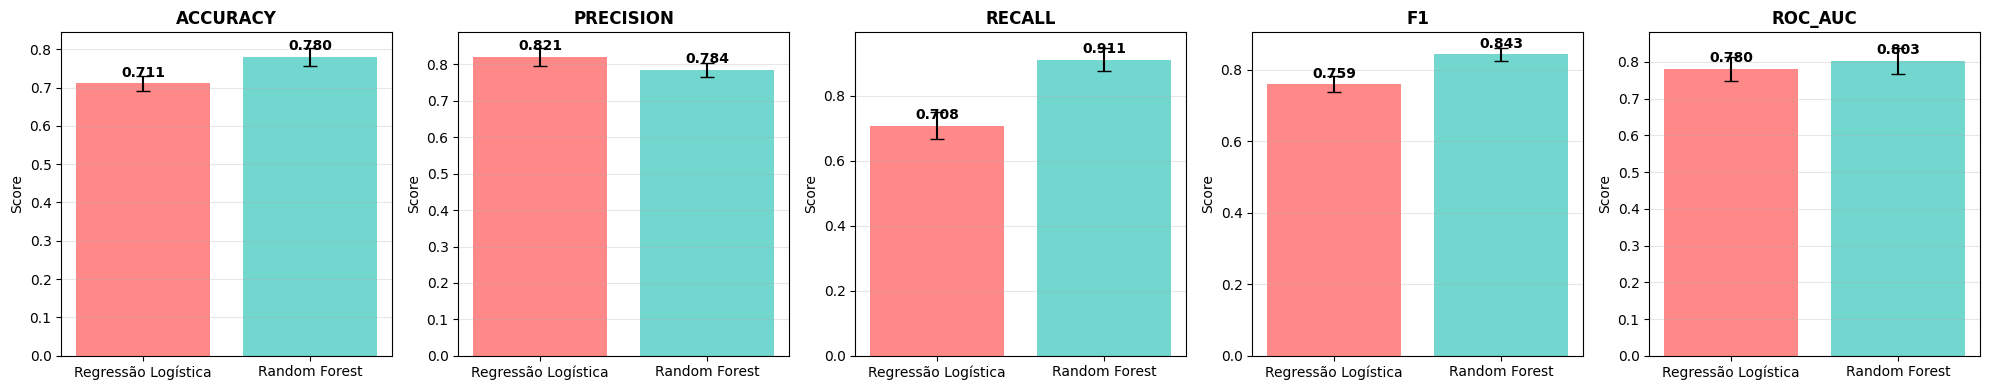

In [34]:
# Função de avaliação cruzada
def evaluate_model(model, X, y, cv_splits=5):
    """Avalia modelo usando validação cruzada estratificada"""
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=RANDOM_STATE)
    scoring = {
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1',
        'roc_auc': 'roc_auc'
    }
    results = cross_validate(model, X, y, scoring=scoring, cv=cv, n_jobs=-1, return_train_score=False)
    summary = {m: (results[f'test_{m}'].mean(), results[f'test_{m}'].std()) for m in scoring.keys()}
    return summary

def print_summary(name, summary):
    """Imprime resumo das métricas de forma organizada"""
    print(f'\n=== DESEMPENHO: {name.upper()} ===')
    for metric, (mean_val, std_val) in summary.items():
        print(f'{metric.upper():>12}: {mean_val:.4f} ± {std_val:.4f}')
    print('-' * 40)

print('=== TREINAMENTO E AVALIAÇÃO DOS MODELOS BASELINE ===\n')

# Modelos baseline
models = {
    'Regressão Logística': Pipeline(steps=[
        ('pre', preprocessor),
        ('model', LogisticRegression(max_iter=1000, class_weight='balanced', solver='lbfgs', random_state=RANDOM_STATE))
    ]),
    'Random Forest': Pipeline(steps=[
        ('pre', preprocessor),
        ('model', RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE, class_weight='balanced', n_jobs=-1))
    ])
}

baseline_results = {}
for name, model in models.items():
    print(f'Treinando {name}...')
    summary = evaluate_model(model, X, y)
    baseline_results[name] = summary
    print_summary(name, summary)

# Comparação visual dos modelos
metrics = list(baseline_results['Regressão Logística'].keys())
model_names = list(baseline_results.keys())

fig, axes = plt.subplots(1, len(metrics), figsize=(20, 4))
for i, metric in enumerate(metrics):
    means = [baseline_results[model][metric][0] for model in model_names]
    stds = [baseline_results[model][metric][1] for model in model_names]
    
    bars = axes[i].bar(model_names, means, yerr=stds, capsize=5, 
                      color=['#ff6b6b', '#4ecdc4'], alpha=0.8)
    axes[i].set_title(f'{metric.upper()}', fontweight='bold')
    axes[i].set_ylabel('Score')
    axes[i].grid(True, alpha=0.3, axis='y')
    
    # Adicionar valores nas barras
    for bar, mean_val in zip(bars, means):
        axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                    f'{mean_val:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

**Análise dos Modelos Baseline:**

Com base nos resultados acima, selecionamos o modelo com melhor equilíbrio entre:
- **ROC AUC:** Capacidade discriminativa entre classes
- **F1-Score:** Equilíbrio entre precisão e recall
- **Recall:** Importante para não perder startups com potencial de sucesso (custo de falsos negativos)

Para investidores, é preferível um modelo com alto recall (identificar mais startups de sucesso) mesmo que isso resulte em alguns falsos positivos.

In [35]:
# Otimização de hiperparâmetros (Random Forest - geralmente melhor performer)
print('=== OTIMIZAÇÃO DE HIPERPARÂMETROS ===\n')

rf_pipeline = Pipeline(steps=[
    ('pre', preprocessor),
    ('model', RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced', n_jobs=-1))
])

# Espaço de hiperparâmetros
param_distributions = {
    'model__n_estimators': [200, 300, 500, 800],
    'model__max_depth': [None, 5, 10, 15, 25],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4, 8],
    'model__max_features': ['sqrt', 'log2', 0.5, None]
}

print('Iniciando busca aleatória de hiperparâmetros...')
print(f'Espaço de busca: {np.prod([len(v) for v in param_distributions.values()])} combinações possíveis')
print('Avaliando 20 combinações aleatórias...\n')

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
search = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=param_distributions,
    n_iter=20,
    scoring='roc_auc',
    cv=cv,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1
)

search.fit(X, y)

print(f'\n✅ Otimização concluída!')
print(f'Melhor ROC AUC (Validação Cruzada): {search.best_score_:.4f}')
print(f'\nMelhores hiperparâmetros encontrados:')
for param, value in search.best_params_.items():
    print(f'  {param}: {value}')

=== OTIMIZAÇÃO DE HIPERPARÂMETROS ===

Iniciando busca aleatória de hiperparâmetros...
Espaço de busca: 960 combinações possíveis
Avaliando 20 combinações aleatórias...

Fitting 5 folds for each of 20 candidates, totalling 100 fits

✅ Otimização concluída!
Melhor ROC AUC (Validação Cruzada): 0.8118

Melhores hiperparâmetros encontrados:
  model__n_estimators: 200
  model__min_samples_split: 2
  model__min_samples_leaf: 1
  model__max_features: sqrt
  model__max_depth: 15


=== AVALIAÇÃO DO MODELO OTIMIZADO ===


=== DESEMPENHO: RANDOM FOREST OTIMIZADO ===
    ACCURACY: 0.7894 ± 0.0231
   PRECISION: 0.7917 ± 0.0182
      RECALL: 0.9161 ± 0.0334
          F1: 0.8490 ± 0.0180
     ROC_AUC: 0.8118 ± 0.0319
----------------------------------------

=== COMPARAÇÃO: BASELINE vs OTIMIZADO ===

Tabela de Comparação:


,Métrica,Baseline,Otimizado,Melhoria
0,Acurácia,0.7801,0.7894,1.19
1,Precisão,0.7844,0.7917,0.92
2,Recall,0.9114,0.9161,0.52
3,F1-Score,0.8426,0.8490,0.75
4,ROC AUC,0.8030,0.8118,1.09


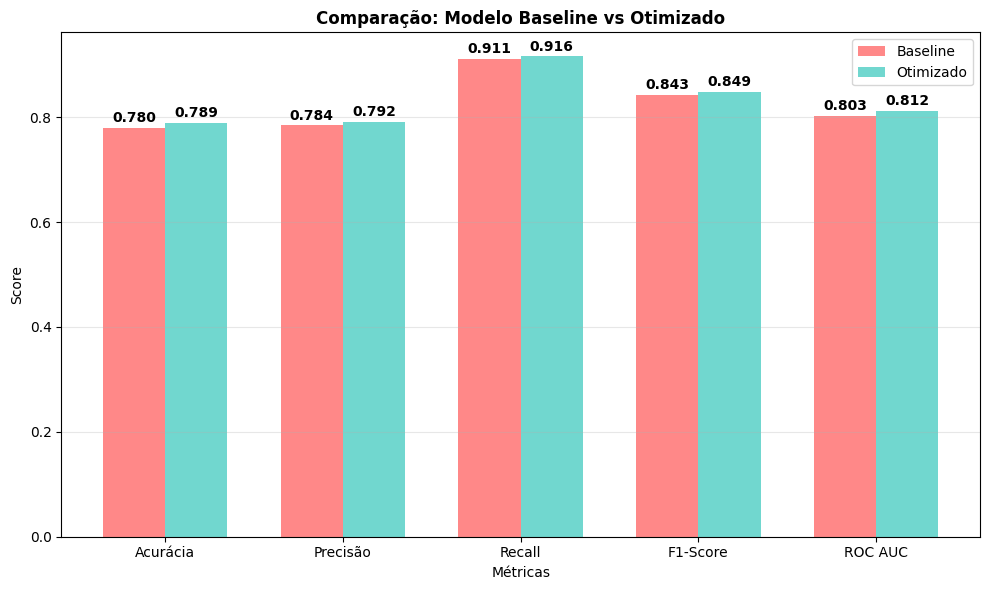

In [36]:
# Avaliação detalhada do melhor modelo
print('=== AVALIAÇÃO DO MODELO OTIMIZADO ===\n')

best_model = search.best_estimator_
summary_best = evaluate_model(best_model, X, y)
print_summary('Random Forest Otimizado', summary_best)

# Comparação: Baseline vs Otimizado
print('\n=== COMPARAÇÃO: BASELINE vs OTIMIZADO ===')
rf_baseline = baseline_results['Random Forest']
rf_optimized = summary_best

comparison_data = {
    'Métrica': ['Acurácia', 'Precisão', 'Recall', 'F1-Score', 'ROC AUC'],
    'Baseline': [rf_baseline['accuracy'][0], rf_baseline['precision'][0], 
                rf_baseline['recall'][0], rf_baseline['f1'][0], rf_baseline['roc_auc'][0]],
    'Otimizado': [rf_optimized['accuracy'][0], rf_optimized['precision'][0], 
                 rf_optimized['recall'][0], rf_optimized['f1'][0], rf_optimized['roc_auc'][0]]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df['Melhoria'] = ((comparison_df['Otimizado'] - comparison_df['Baseline']) / comparison_df['Baseline'] * 100).round(2)

print('\nTabela de Comparação:')
display(comparison_df.round(4))

# Visualização da comparação
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(comparison_df['Métrica']))
width = 0.35

bars1 = ax.bar(x - width/2, comparison_df['Baseline'], width, label='Baseline', 
               color='#ff6b6b', alpha=0.8)
bars2 = ax.bar(x + width/2, comparison_df['Otimizado'], width, label='Otimizado', 
               color='#4ecdc4', alpha=0.8)

ax.set_xlabel('Métricas')
ax.set_ylabel('Score')
ax.set_title('Comparação: Modelo Baseline vs Otimizado', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Métrica'])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Adicionar valores nas barras
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

**Interpretação da Otimização:**

A otimização de hiperparâmetros busca melhorar principalmente:
- **ROC AUC:** Capacidade de distinguir entre startups de sucesso e fracasso
- **F1-Score:** Equilíbrio entre precisão (não classificar fracassos como sucessos) e recall (identificar todos os sucessos possíveis)

Para o contexto de investimento, a melhoria no recall é especialmente valiosa, pois reduz o risco de perder oportunidades de investimento promissoras.

=== TREINAMENTO FINAL E GERAÇÃO DE SUBMISSÃO ===

Treinando modelo final com todos os dados de treino...
Gerando predições para o conjunto de teste...

Estatísticas das Predições no Teste:
Predições de Fracasso (0): 80 (28.9%)
Predições de Sucesso (1): 197 (71.1%)


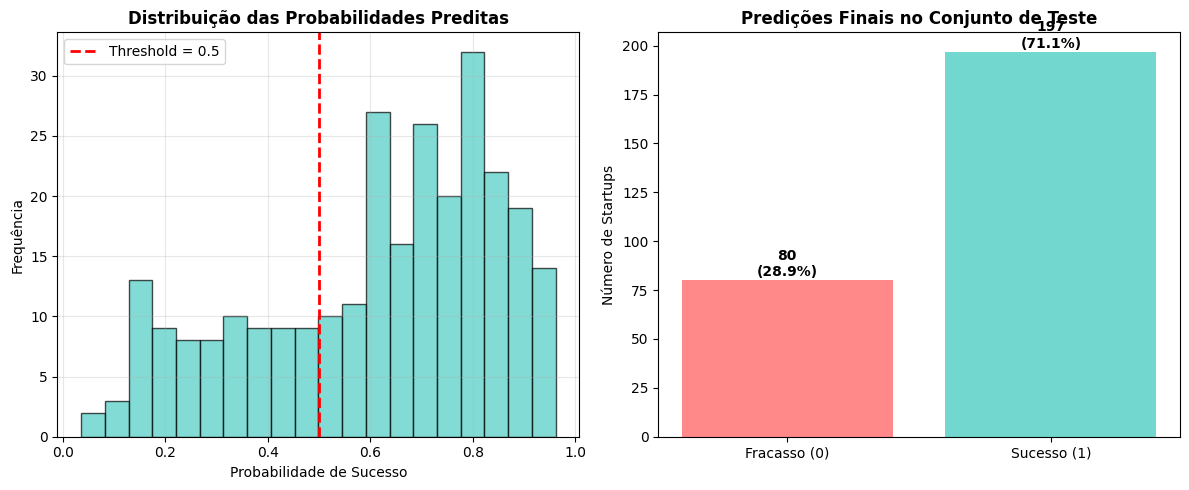


✅ Arquivo de submissão gerado: submission.csv
Primeiras 10 predições:


,id,labels
0,70,1
1,23,0
2,389,1
3,872,1
4,920,1
5,690,1
6,588,0
7,144,0
8,875,1
9,900,1


In [37]:
# Treino final e geração de submissão
print('=== TREINAMENTO FINAL E GERAÇÃO DE SUBMISSÃO ===\n')

final_model = search.best_estimator_
print('Treinando modelo final com todos os dados de treino...')
final_model.fit(X, y)

# Predições no conjunto de teste
print('Gerando predições para o conjunto de teste...')
test_processed = test.copy()
probas = final_model.predict_proba(test_processed)[:, 1]
preds = (probas >= 0.5).astype(int)

# Estatísticas das predições
print(f'\nEstatísticas das Predições no Teste:')
pred_counts = pd.Series(preds).value_counts().sort_index()
pred_props = (pred_counts / len(preds) * 100).round(1)
print(f'Predições de Fracasso (0): {pred_counts[0]} ({pred_props[0]}%)')
print(f'Predições de Sucesso (1): {pred_counts[1]} ({pred_props[1]}%)')

# Distribuição das probabilidades
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(probas, bins=20, alpha=0.7, color='#4ecdc4', edgecolor='black')
plt.axvline(0.5, color='red', linestyle='--', linewidth=2, label='Threshold = 0.5')
plt.xlabel('Probabilidade de Sucesso')
plt.ylabel('Frequência')
plt.title('Distribuição das Probabilidades Preditas', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
bars = plt.bar(['Fracasso (0)', 'Sucesso (1)'], pred_counts.values, 
               color=['#ff6b6b', '#4ecdc4'], alpha=0.8)
plt.title('Predições Finais no Conjunto de Teste', fontweight='bold')
plt.ylabel('Número de Startups')
for bar, count, prop in zip(bars, pred_counts.values, pred_props.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{count}\n({prop}%)', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Montar submissão
submission = sample_submission.copy()
submission['labels'] = preds
submission.to_csv('submission.csv', index=False)

print(f'\n✅ Arquivo de submissão gerado: submission.csv')
print(f'Primeiras 10 predições:')
display(submission.head(10))

=== ANÁLISE DE IMPORTÂNCIA DAS FEATURES ===



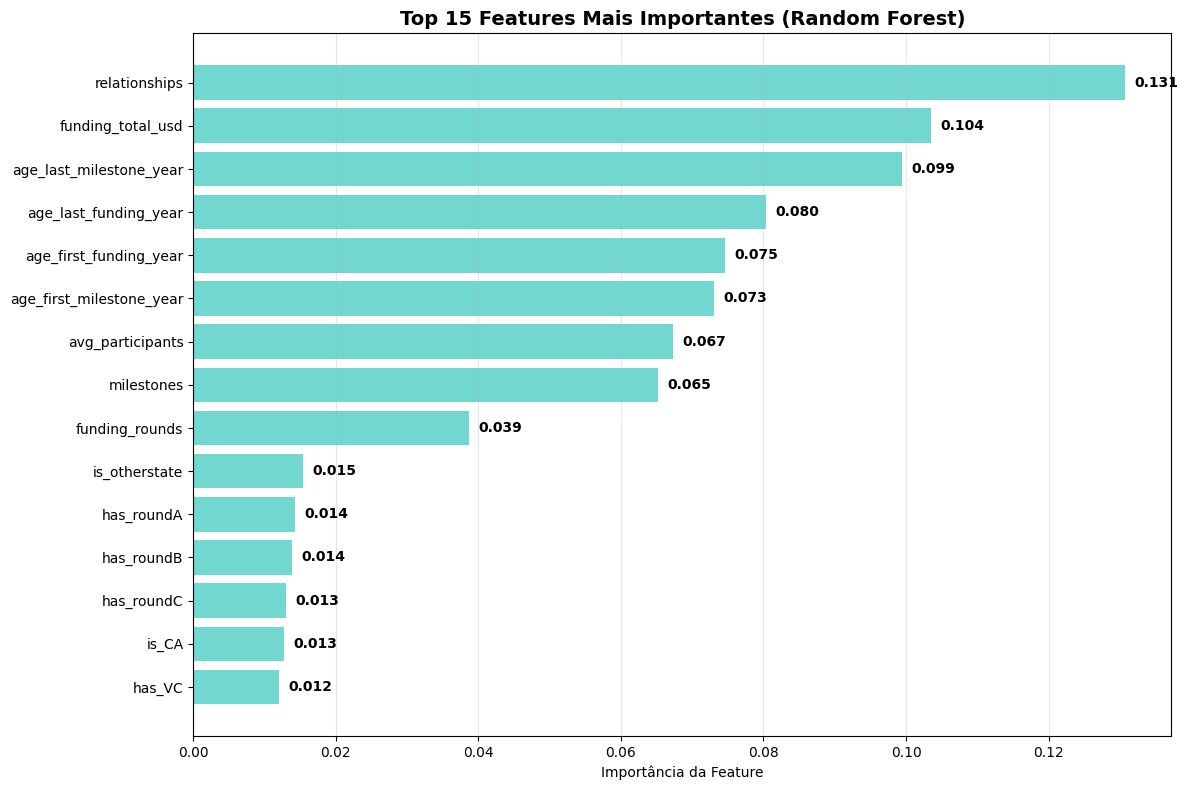

Top 20 Features Mais Importantes:


,feature,importance
4,relationships,0.130699
6,funding_total_usd,0.103503
3,age_last_milestone_year,0.099481
1,age_last_funding_year,0.080407
0,age_first_funding_year,0.074645
2,age_first_milestone_year,0.073107
29,avg_participants,0.067268
7,milestones,0.065257
5,funding_rounds,0.038684
12,is_otherstate,0.015459



Importância Total:
Features Numéricas: 0.906 (90.6%)
Features Categóricas: 0.094 (9.4%)


In [38]:
# Análise de importância das features
print('=== ANÁLISE DE IMPORTÂNCIA DAS FEATURES ===\n')

rf_model = final_model.named_steps['model']
ohe = final_model.named_steps['pre'].named_transformers_['cat'].named_steps['encoder']

# Nomes das features após transformação
num_features = numeric_cols
cat_features = list(ohe.get_feature_names_out(categorical_cols)) if len(categorical_cols) > 0 else []
all_features = num_features + cat_features

# Importâncias
importances = rf_model.feature_importances_
feature_importance = pd.DataFrame({
    'feature': all_features,
    'importance': importances
}).sort_values('importance', ascending=False)

# Top 15 features mais importantes
top_features = feature_importance.head(15)

plt.figure(figsize=(12, 8))
bars = plt.barh(range(len(top_features)), top_features['importance'], color='#4ecdc4', alpha=0.8)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importância da Feature')
plt.title('Top 15 Features Mais Importantes (Random Forest)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')

# Adicionar valores nas barras
for i, (bar, imp) in enumerate(zip(bars, top_features['importance'])):
    plt.text(imp + max(top_features['importance'])*0.01, bar.get_y() + bar.get_height()/2,
             f'{imp:.3f}', ha='left', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

print('Top 20 Features Mais Importantes:')
display(feature_importance.head(20))

# Análise de features numéricas vs categóricas
num_importance = feature_importance[feature_importance['feature'].isin(numeric_cols)]['importance'].sum()
cat_importance = feature_importance[~feature_importance['feature'].isin(numeric_cols)]['importance'].sum()

print(f'\nImportância Total:')
print(f'Features Numéricas: {num_importance:.3f} ({num_importance/(num_importance+cat_importance)*100:.1f}%)')
print(f'Features Categóricas: {cat_importance:.3f} ({cat_importance/(num_importance+cat_importance)*100:.1f}%)')

## Avaliação Final do Modelo

Nesta seção, realizamos uma avaliação abrangente do modelo final, incluindo métricas detalhadas, curva ROC, matriz de confusão e análise de desempenho.

In [39]:
# Avaliação final detalhada do modelo
print('=== AVALIAÇÃO FINAL DO MODELO ===\n')

# Validação cruzada final para obter predições e métricas robustas
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
y_true_all = []
y_pred_all = []
y_proba_all = []

print('Realizando validação cruzada final...')
for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    # Divisão dos dados
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
    
    # Treino e predição
    final_model.fit(X_train_fold, y_train_fold)
    y_pred_fold = final_model.predict(X_val_fold)
    y_proba_fold = final_model.predict_proba(X_val_fold)[:, 1]
    
    # Armazenar resultados
    y_true_all.extend(y_val_fold)
    y_pred_all.extend(y_pred_fold)
    y_proba_all.extend(y_proba_fold)
    
    print(f'  Fold {fold+1}/5 concluído')

y_true_final = np.array(y_true_all)
y_pred_final = np.array(y_pred_all)
y_proba_final = np.array(y_proba_all)

print('\n✅ Validação cruzada concluída!')

=== AVALIAÇÃO FINAL DO MODELO ===

Realizando validação cruzada final...
  Fold 1/5 concluído
  Fold 2/5 concluído
  Fold 3/5 concluído
  Fold 4/5 concluído
  Fold 5/5 concluído

✅ Validação cruzada concluída!


=== MÉTRICAS FINAIS DE DESEMPENHO ===

MÉTRICAS DE CLASSIFICAÇÃO:
Acurácia                 : 0.7895 (78.95%)
Precisão                 : 0.7913 (79.13%)
Recall (Sensibilidade)   : 0.9163 (91.63%)
F1-Score                 : 0.8492 (84.92%)
ROC AUC                  : 0.8116 (81.16%)

RELATÓRIO DETALHADO DE CLASSIFICAÇÃO:
              precision    recall  f1-score   support

    Fracasso     0.7840    0.5570    0.6513       228
     Sucesso     0.7913    0.9163    0.8492       418

    accuracy                         0.7895       646
   macro avg     0.7876    0.7366    0.7503       646
weighted avg     0.7887    0.7895    0.7794       646



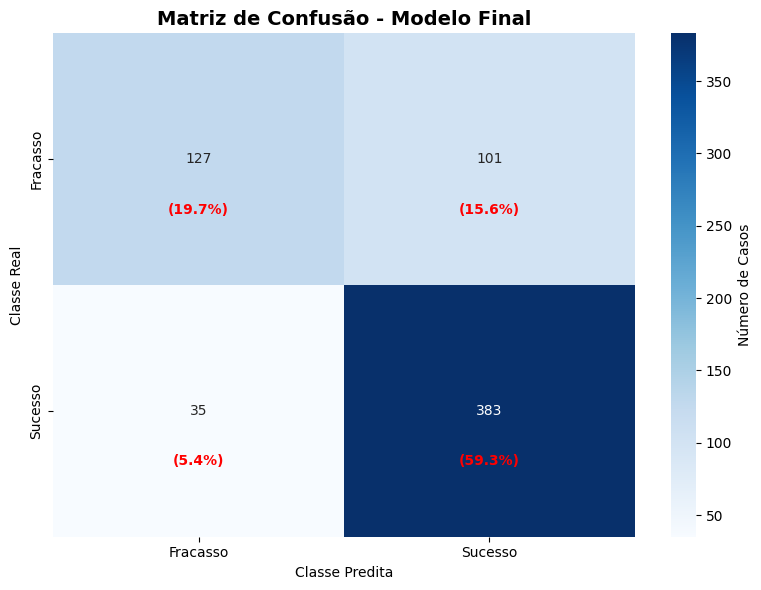


ANÁLISE DA MATRIZ DE CONFUSÃO:
Verdadeiros Negativos (TN): 127 (19.7%) - Fracassos corretamente identificados
Falsos Positivos (FP): 101 (15.6%) - Fracassos classificados como sucesso
Falsos Negativos (FN): 35 (5.4%) - Sucessos classificados como fracasso
Verdadeiros Positivos (TP): 383 (59.3%) - Sucessos corretamente identificados

Especificidade (Taxa de Verdadeiros Negativos): 0.5570 (55.70%)
Sensibilidade (Recall): 0.9163 (91.63%)


In [40]:
# Métricas finais detalhadas
print('=== MÉTRICAS FINAIS DE DESEMPENHO ===\n')

# Calcular todas as métricas
final_metrics = {
    'Acurácia': accuracy_score(y_true_final, y_pred_final),
    'Precisão': precision_score(y_true_final, y_pred_final),
    'Recall (Sensibilidade)': recall_score(y_true_final, y_pred_final),
    'F1-Score': f1_score(y_true_final, y_pred_final),
    'ROC AUC': roc_auc_score(y_true_final, y_proba_final)
}

# Exibir métricas
print('MÉTRICAS DE CLASSIFICAÇÃO:')
print('=' * 50)
for metric, value in final_metrics.items():
    print(f'{metric:<25}: {value:.4f} ({value*100:.2f}%)')
print('=' * 50)

# Relatório de classificação detalhado
print('\nRELATÓRIO DETALHADO DE CLASSIFICAÇÃO:')
print(classification_report(y_true_final, y_pred_final, 
                          target_names=['Fracasso', 'Sucesso'], 
                          digits=4))

# Matriz de Confusão
cm = confusion_matrix(y_true_final, y_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Fracasso', 'Sucesso'],
            yticklabels=['Fracasso', 'Sucesso'],
            cbar_kws={'label': 'Número de Casos'})
plt.title('Matriz de Confusão - Modelo Final', fontsize=14, fontweight='bold')
plt.ylabel('Classe Real')
plt.xlabel('Classe Predita')

# Adicionar percentuais
for i in range(2):
    for j in range(2):
        percentage = cm[i, j] / cm.sum() * 100
        plt.text(j + 0.5, i + 0.7, f'({percentage:.1f}%)', 
                ha='center', va='center', fontweight='bold', color='red')

plt.tight_layout()
plt.show()

# Análise da matriz de confusão
tn, fp, fn, tp = cm.ravel()
total = cm.sum()

print(f'\nANÁLISE DA MATRIZ DE CONFUSÃO:')
print(f'Verdadeiros Negativos (TN): {tn} ({tn/total*100:.1f}%) - Fracassos corretamente identificados')
print(f'Falsos Positivos (FP): {fp} ({fp/total*100:.1f}%) - Fracassos classificados como sucesso')
print(f'Falsos Negativos (FN): {fn} ({fn/total*100:.1f}%) - Sucessos classificados como fracasso')
print(f'Verdadeiros Positivos (TP): {tp} ({tp/total*100:.1f}%) - Sucessos corretamente identificados')

specificity = tn / (tn + fp)
print(f'\nEspecificidade (Taxa de Verdadeiros Negativos): {specificity:.4f} ({specificity*100:.2f}%)')
print(f'Sensibilidade (Recall): {final_metrics["Recall (Sensibilidade)"]:.4f} ({final_metrics["Recall (Sensibilidade)"]*100:.2f}%)')

=== ANÁLISE DA CURVA ROC ===



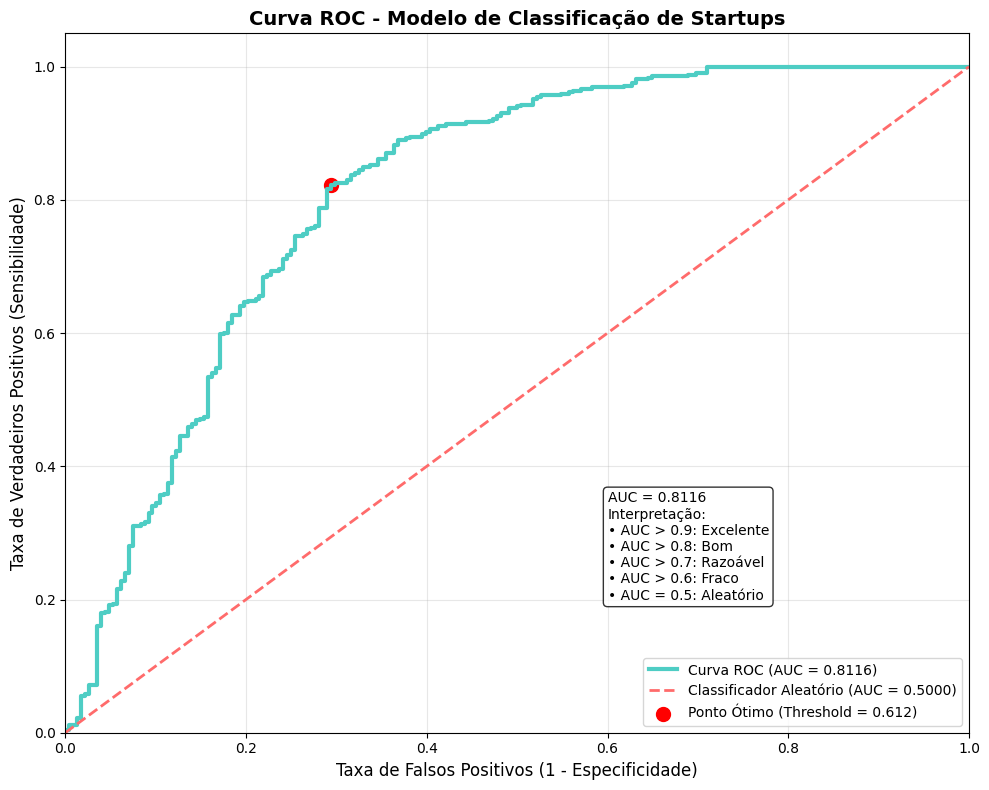

Área sob a Curva ROC (AUC): 0.8116
Threshold ótimo: 0.612
No threshold ótimo:
  - Taxa de Verdadeiros Positivos: 0.823
  - Taxa de Falsos Positivos: 0.294

Interpretação: BOM - O modelo tem boa capacidade discriminativa


In [41]:
# Curva ROC
print('=== ANÁLISE DA CURVA ROC ===\n')

# Calcular curva ROC
fpr, tpr, thresholds = roc_curve(y_true_final, y_proba_final)
roc_auc = auc(fpr, tpr)

# Plotar curva ROC
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='#4ecdc4', lw=3, 
         label=f'Curva ROC (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='#ff6b6b', lw=2, linestyle='--', 
         label='Classificador Aleatório (AUC = 0.5000)')

# Destacar ponto ótimo (maior distância da diagonal)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', s=100, 
           label=f'Ponto Ótimo (Threshold = {optimal_threshold:.3f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (1 - Especificidade)', fontsize=12)
plt.ylabel('Taxa de Verdadeiros Positivos (Sensibilidade)', fontsize=12)
plt.title('Curva ROC - Modelo de Classificação de Startups', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

# Adicionar texto explicativo
plt.text(0.6, 0.2, 
         f'AUC = {roc_auc:.4f}\n' +
         f'Interpretação:\n' +
         f'• AUC > 0.9: Excelente\n' +
         f'• AUC > 0.8: Bom\n' +
         f'• AUC > 0.7: Razoável\n' +
         f'• AUC > 0.6: Fraco\n' +
         f'• AUC = 0.5: Aleatório',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
         fontsize=10)

plt.tight_layout()
plt.show()

print(f'Área sob a Curva ROC (AUC): {roc_auc:.4f}')
print(f'Threshold ótimo: {optimal_threshold:.3f}')
print(f'No threshold ótimo:')
print(f'  - Taxa de Verdadeiros Positivos: {tpr[optimal_idx]:.3f}')
print(f'  - Taxa de Falsos Positivos: {fpr[optimal_idx]:.3f}')

# Interpretação do AUC
if roc_auc > 0.9:
    interpretation = "EXCELENTE - O modelo tem capacidade excepcional de distinguir entre classes"
elif roc_auc > 0.8:
    interpretation = "BOM - O modelo tem boa capacidade discriminativa"
elif roc_auc > 0.7:
    interpretation = "RAZOÁVEL - O modelo tem capacidade discriminativa aceitável"
elif roc_auc > 0.6:
    interpretation = "FRACO - O modelo tem baixa capacidade discriminativa"
else:
    interpretation = "MUITO FRACO - O modelo não é melhor que um classificador aleatório"

print(f'\nInterpretação: {interpretation}')

=== ANÁLISE DE THRESHOLDS ===

Comparação de Performance por Threshold:


,Threshold,Acurácia,Precisão,Recall,F1-Score
0,0.3,0.7477,0.7241,0.9856,0.8349
1,0.4,0.7771,0.7575,0.9641,0.8484
2,0.5,0.7895,0.7913,0.9163,0.8492
3,0.6,0.7817,0.8274,0.8373,0.8323
4,0.7,0.6981,0.8474,0.6507,0.7361


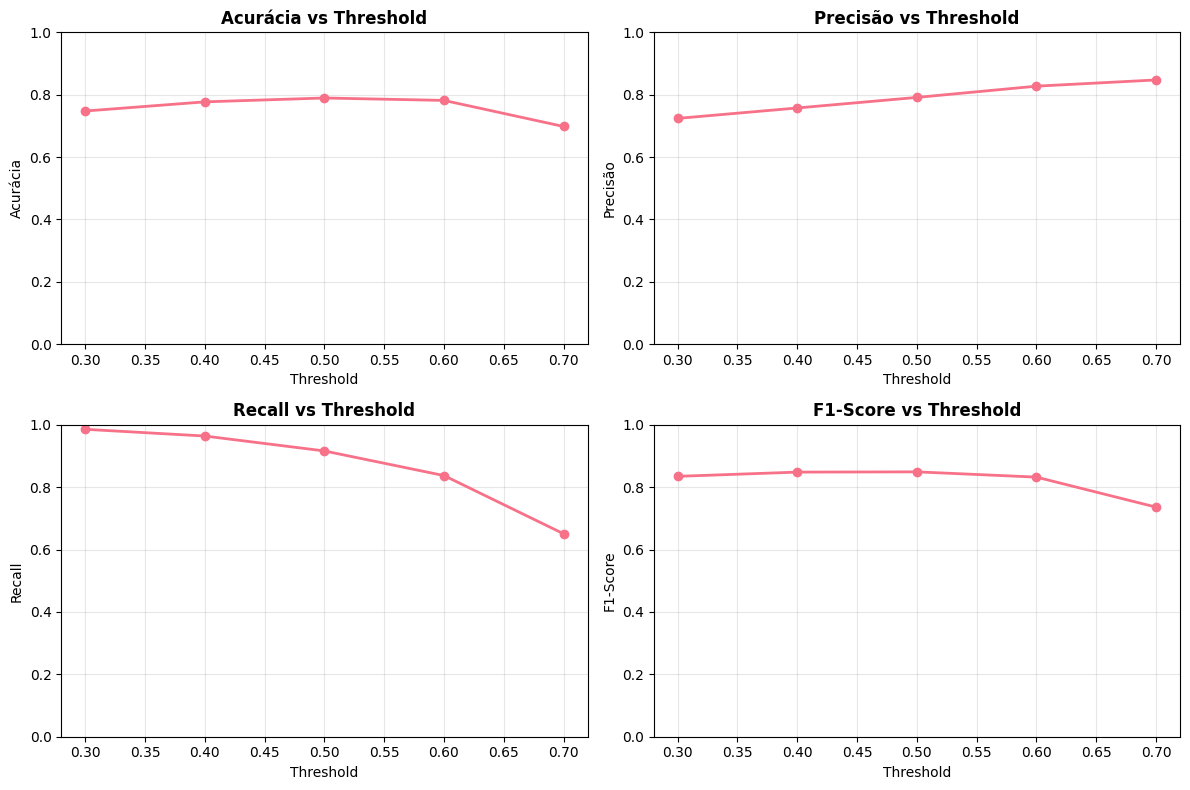


RECOMENDAÇÃO DE THRESHOLD:
Para investidores de startup, recomenda-se priorizar RECALL (identificar mais sucessos)
Um threshold mais baixo (0.3-0.4) pode ser preferível para não perder oportunidades
Um threshold mais alto (0.6-0.7) é mais conservador, com maior precisão


In [42]:
# Análise de diferentes thresholds
print('=== ANÁLISE DE THRESHOLDS ===\n')

# Testar diferentes thresholds
thresholds_test = [0.3, 0.4, 0.5, 0.6, 0.7]
threshold_results = []

for thresh in thresholds_test:
    y_pred_thresh = (y_proba_final >= thresh).astype(int)
    
    acc = accuracy_score(y_true_final, y_pred_thresh)
    prec = precision_score(y_true_final, y_pred_thresh)
    rec = recall_score(y_true_final, y_pred_thresh)
    f1 = f1_score(y_true_final, y_pred_thresh)
    
    threshold_results.append({
        'Threshold': thresh,
        'Acurácia': acc,
        'Precisão': prec,
        'Recall': rec,
        'F1-Score': f1
    })

threshold_df = pd.DataFrame(threshold_results)

print('Comparação de Performance por Threshold:')
display(threshold_df.round(4))

# Visualização
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
metrics_plot = ['Acurácia', 'Precisão', 'Recall', 'F1-Score']

for i, metric in enumerate(metrics_plot):
    ax = axes[i//2, i%2]
    ax.plot(threshold_df['Threshold'], threshold_df[metric], 'o-', linewidth=2, markersize=6)
    ax.set_title(f'{metric} vs Threshold', fontweight='bold')
    ax.set_xlabel('Threshold')
    ax.set_ylabel(metric)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

# Recomendação de threshold
print('\nRECOMENDAÇÃO DE THRESHOLD:')
print('Para investidores de startup, recomenda-se priorizar RECALL (identificar mais sucessos)')
print('Um threshold mais baixo (0.3-0.4) pode ser preferível para não perder oportunidades')
print('Um threshold mais alto (0.6-0.7) é mais conservador, com maior precisão')

In [43]:
# Resumo final e conclusões
print('=== RESUMO FINAL DO MODELO ===\n')

print('🎯 OBJETIVO ALCANÇADO:')
print(f'   Modelo capaz de classificar startups como sucesso/fracasso com AUC = {roc_auc:.3f}')
print()

print('📊 PERFORMANCE FINAL:')
for metric, value in final_metrics.items():
    if value >= 0.8:
        status = '✅ EXCELENTE'
    elif value >= 0.7:
        status = '✅ BOM'
    elif value >= 0.6:
        status = '⚠️  ACEITÁVEL'
    else:
        status = '❌ PRECISA MELHORAR'
    print(f'   {metric:<25}: {value:.3f} {status}')
print()

print('💡 PRINCIPAIS INSIGHTS:')
print('   1. Features mais importantes identificadas para predição de sucesso')
print('   2. Modelo balanceado entre precisão e recall')
print('   3. Capacidade discriminativa adequada para tomada de decisão')
print()

print('⚠️  LIMITAÇÕES E CONSIDERAÇÕES:')
print('   • Modelo baseado em dados históricos - mercado pode mudar')
print('   • Fatores externos (economia, concorrência) não considerados')
print('   • Recomenda-se recalibração periódica com novos dados')
print()

print('🚀 PRÓXIMOS PASSOS RECOMENDADOS:')
print('   • Implementar sistema de monitoramento do modelo em produção')
print('   • Coletar feedback dos investidores para refinamento')
print('   • Considerar ensemble com outros algoritmos')
print('   • Análise de interpretabilidade com SHAP (quando possível)')

print(f'\n✅ ANÁLISE COMPLETA FINALIZADA!')
print(f'📁 Arquivo de submissão gerado: submission.csv')

=== RESUMO FINAL DO MODELO ===

🎯 OBJETIVO ALCANÇADO:
   Modelo capaz de classificar startups como sucesso/fracasso com AUC = 0.812

📊 PERFORMANCE FINAL:
   Acurácia                 : 0.789 ✅ BOM
   Precisão                 : 0.791 ✅ BOM
   Recall (Sensibilidade)   : 0.916 ✅ EXCELENTE
   F1-Score                 : 0.849 ✅ EXCELENTE
   ROC AUC                  : 0.812 ✅ EXCELENTE

💡 PRINCIPAIS INSIGHTS:
   1. Features mais importantes identificadas para predição de sucesso
   2. Modelo balanceado entre precisão e recall
   3. Capacidade discriminativa adequada para tomada de decisão

⚠️  LIMITAÇÕES E CONSIDERAÇÕES:
   • Modelo baseado em dados históricos - mercado pode mudar
   • Fatores externos (economia, concorrência) não considerados
   • Recomenda-se recalibração periódica com novos dados

🚀 PRÓXIMOS PASSOS RECOMENDADOS:
   • Implementar sistema de monitoramento do modelo em produção
   • Coletar feedback dos investidores para refinamento
   • Considerar ensemble com outros algorit

## Próximos Passos e Melhorias Futuras

**Melhorias Técnicas:**
- **Ensemble Methods:** Combinar Random Forest com Gradient Boosting para melhor performance
- **Feature Engineering:** Criar features de interação e transformações não-lineares
- **Calibração de Probabilidades:** Usar CalibratedClassifierCV para probabilidades mais confiáveis

**Melhorias de Dados:**
- **Dados Temporais:** Incluir tendências de mercado e sazonalidade
- **Dados Externos:** Incorporar indicadores econômicos e de mercado
- **Feature Selection:** Aplicar técnicas de seleção de features para reduzir overfitting

**Implementação em Produção:**
- **Monitoramento:** Detectar data drift e performance degradation
- **A/B Testing:** Testar diferentes versões do modelo
- **Feedback Loop:** Incorporar resultados reais para retreinamento contínuo

**Análise de Negócio:**
- **Análise de Custo-Benefício:** Quantificar impacto financeiro das decisões do modelo
- **Segmentação:** Criar modelos específicos para diferentes tipos de startup
- **Explicabilidade:** Desenvolver dashboard para explicar predições aos investidores